In [1]:
import keras

from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.layers.core import Dense,Flatten,Dropout
from keras.models import Model,load_model
from keras.layers import Input,add,BatchNormalization
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


c:\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from keras.callbacks import ModelCheckpoint
checkpoint=ModelCheckpoint("weights-imporovement-{epoch:02d}-{val_acc:.2f}.hdf5",
                           monitor='val_loss',verbose=1,save_best_only=True,mode='max')

In [2]:
#EXTRACTING THE DATA FROM TAR FILE
num_classes=7

with open('fer2013.csv') as f:
    content=f.readlines()
lines=np.array(content)
nom=lines.size
Xtr, Ytr, Xte, Yte= [], [], [], []
for i in range(1,nom):
    try:
        emotion,pixels,Usage =lines[i].split(",")
        val=pixels.split(" ")
        pixx=np.array(val,'float32')
        emotion=keras.utils.to_categorical(emotion,num_classes)
        
        if 'Training' in Usage:
            Ytr.append(emotion)
            Xtr.append(pixx)
        elif 'PrivateTest' in Usage:
            Yte.append(emotion)
            Xte.append(pixx)
    except:
        print('Over')
   

In [3]:
#PRE-PROCESSING THE DATA
Xtr=np.array(Xtr,'float32')/255.
Ytr=np.array(Ytr,'float32')/255.

Xte=np.array(Xte,'float32')/255.
Yte=np.array(Yte,'float32')/255.      
 
exp={0:'angry',1:'disgust',2:'fear',3:'happy',4:'sad',5:'surprise',6:'neutral'}

Xtr=Xtr.reshape(Xtr.shape[0],48,48)
Xte=Xte.reshape(Xte.shape[0],48,48)


In [4]:
#DATA-AUGMENTATION
Xfl = Xtr[:, :, ::-1]  # simple slice to flip all images
Yfl=Ytr
X=np.concatenate((Xtr,Xfl),axis=0)
Y=np.concatenate((Ytr,Yfl),axis=0)

sad


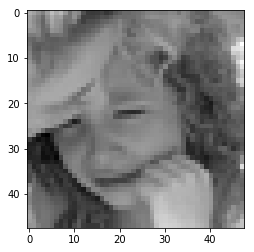

In [11]:
#LOOKING AT A RANDOM IMAGE AND ITS LABEL FROM THE TRAINING SET
k=np.random.randint(1,X.shape[0])       
plt.imshow(X[k].reshape(48,48),cmap='gray')
ar=np.argmax(Y[k])
print(exp[ar])      
#print(Yte[k])

In [6]:
#RESHAPING THE IMAGES
X=X.reshape(X.shape[0],48,48,1)
Xte=Xte.reshape(Xte.shape[0],48,48,1)

In [18]:
#####DEFINING OUR MODEL USING THE KERAS FUNCTIONAL API
x=Input(shape=(48,48,1))
con1=Conv2D(8,(3,3),activation='relu')(x)
max1=MaxPooling2D( (2,2))(con1)
dr1=Dropout(0.05)(max1)
con2=Conv2D(16,(3,3),activation='relu')(dr1)
max2=MaxPooling2D((2,2))(con2)
con3=Conv2D(16,(3,3),activation='relu')(max2)
max3=MaxPooling2D((2,2))(con3)
flat=Flatten()(max3)
dens1=Dense(256,activation='relu')(flat)
ba=BatchNormalization(epsilon=0.0002)(dens1)
dens2=Dense(72,activation='relu')(ba)
op=Dense(7,activation='softmax')(dens2)

faces=Model(x,op)     

faces.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [20]:
faces.summary()
esm=EarlyStopping(monitor='val_loss',patience=3)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 8)         80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 16)          2320      
__________

In [ ]:
Hist=faces.fit(X,Y,batch_size=128,epochs=30,callbacks=[esm,checkpoint],validation_data=(Xte,Yte),
          shuffle=True)


In [22]:
faces.save('newcnn.h5')

In [12]:
#neww=load_model('model_2layer_2_2_pool.h5')